In [301]:
!pip install pandas seaborn matplotlib scikit-learn


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [302]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

### Download dataset from KaggleHub and load into a dataframe

In [303]:
KAGGLE_USERNAME = os.getenv("KAGGLE_USERNAME")
KAGGLE_KEY = os.getenv("KAGGLE_KEY")

In [304]:
os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

In [305]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# download dataset from kaggle and load it to a dataframe
df = kagglehub.load_dataset(
     KaggleDatasetAdapter.PANDAS,
     "alikalwar/uae-used-car-prices-and-features-10k-listings",
     "uae_used_cars_10k.csv",
)

In [306]:
df.head()

,Make,Model,Year,Price,Mileage,Body Type,Cylinders,Transmission,Fuel Type,Color,Location,Description
0,toyota,camry,2016,47819,156500,Sedan,4,Automatic Transmission,Gasoline,Black,Dubai,"2016 toyota camry with Rear camera, Leather se..."
1,kia,sorento,2013,61250,169543,SUV,4,Automatic Transmission,Gasoline,Grey,Abu Dhabi,"2013 kia sorento with Sunroof, Adaptive cruise..."
2,mini,cooper,2023,31861,221583,Soft Top Convertible,4,Automatic Transmission,Gasoline,Grey,Dubai,"2023 mini cooper with Adaptive cruise control,..."
3,nissan,altima,2016,110322,69754,Sedan,4,Automatic Transmission,Gasoline,Red,Dubai,"2016 nissan altima with Rear camera, Adaptive ..."
4,toyota,land-cruiser-76-series,2020,139994,71399,Pick Up Truck,4,Manual Transmission,Gasoline,White,Dubai,2020 toyota land-cruiser-76-series with Adapti...


In [307]:
no_of_car_listings = len(df)
print(f"dataset has {no_of_car_listings} data records")

dataset has 10000 data records


### Analyze the dataset before pre processing

In [308]:
# Analyze dataset features
print("<-------------- features of dataset ---------------------------->")
print(df.info())

# get statistical summary of the numerical features before pre-process
print("<-------------- statistical summary of numerical features ---------------------------->")
print(df.describe())

<-------------- features of dataset ---------------------------->
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Make          10000 non-null  object
 1   Model         10000 non-null  object
 2   Year          10000 non-null  int64 
 3   Price         10000 non-null  int64 
 4   Mileage       10000 non-null  int64 
 5   Body Type     10000 non-null  object
 6   Cylinders     9895 non-null   object
 7   Transmission  10000 non-null  object
 8   Fuel Type     10000 non-null  object
 9   Color         10000 non-null  object
 10  Location      10000 non-null  object
 11  Description   10000 non-null  object
dtypes: int64(3), object(9)
memory usage: 937.6+ KB
None
<-------------- statistical summary of numerical features ---------------------------->
               Year         Price        Mileage
count  10000.000000  1.000000e+04   10000.00

In [309]:
# identify categorical and numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Features:")
for n in numerical_features:
     print(n)
     
categorical_features = df.select_dtypes(include=['object', 'category']).columns
print("Categorical Features:")
for c in categorical_features:
     print(c)

Numerical Features:
Year
Price
Mileage
Categorical Features:
Make
Model
Body Type
Cylinders
Transmission
Fuel Type
Color
Location
Description


In [310]:
for c in categorical_features: 
     print(f"no of {c} categories: {len(df[c].value_counts())}")
     print(f"categories of {c}")
     print(df[c].value_counts())
     print("\n")

no of Make categories: 65
categories of Make
Make
mercedes-benz    1486
nissan            925
toyota            893
bmw               698
ford              541
                 ... 
gac                 1
haval               1
baic                1
smart               1
morgan              1
Name: count, Length: 65, dtype: int64


no of Model categories: 488
categories of Model
Model
patrol               386
s-class              288
g-class              257
land-cruiser         208
range-rover-sport    198
                    ... 
centennial             1
aero-8                 1
dtsde-ville            1
trailblazer            1
ct5                    1
Name: count, Length: 488, dtype: int64


no of Body Type categories: 13
categories of Body Type
Body Type
SUV                     4607
Sedan                   2790
Coupe                    837
Pick Up Truck            432
Hatchback                334
Sports Car               270
Van                      143
Hard Top Convertible     139
C

### Remove irrelevant features

In [311]:
# for price prediction of these use vehicles description of the each car is not required. 
# also the city in UAE where the car is available, does not usually influence its price
# therefore we can remove them considering as an irrelevant features
df=df.drop(["Location","Description"],axis=1)
df.head(5)

,Make,Model,Year,Price,Mileage,Body Type,Cylinders,Transmission,Fuel Type,Color
0,toyota,camry,2016,47819,156500,Sedan,4,Automatic Transmission,Gasoline,Black
1,kia,sorento,2013,61250,169543,SUV,4,Automatic Transmission,Gasoline,Grey
2,mini,cooper,2023,31861,221583,Soft Top Convertible,4,Automatic Transmission,Gasoline,Grey
3,nissan,altima,2016,110322,69754,Sedan,4,Automatic Transmission,Gasoline,Red
4,toyota,land-cruiser-76-series,2020,139994,71399,Pick Up Truck,4,Manual Transmission,Gasoline,White


### Handle missing values

In [312]:
# find missing values
missing_values = df.isnull().sum()
print(missing_values)

# only `cylinders` feature has missing values

Make              0
Model             0
Year              0
Price             0
Mileage           0
Body Type         0
Cylinders       105
Transmission      0
Fuel Type         0
Color             0
dtype: int64


#### upon manually inspecting the dataset some of the values of Cylinders feature contains 'Unknown' string value. therefore it makes sense to remove the data with 'Unknown' Cylinder values because they are not meaningful for the analysis and can lead to poor performance of prediction models.

In [313]:
# Check the distribution of values in the Cylinders column
cylinder_counts = df['Cylinders'].value_counts(dropna=False)
print(cylinder_counts)

Cylinders
6          3420
8          3003
4          2929
12          340
NaN         105
3            53
5            52
Unknown      50
10           48
Name: count, dtype: int64


In [314]:
# replace 'Unknown' values with NaN
df['Cylinders'] = df['Cylinders'].replace('Unknown', float('nan'))

In [315]:
# Check the distribution of values in the Cylinders after replacing with NaN
cylinder_counts = df['Cylinders'].value_counts(dropna=False)
print(cylinder_counts)

missing_percentage = (df["Cylinders"].isnull().sum() / len(df)) * 100
print(f"percentage of missing values in Cylinders: {missing_percentage}")

Cylinders
6      3420
8      3003
4      2929
12      340
NaN     155
3        53
5        52
10       48
Name: count, dtype: int64
percentage of missing values in Cylinders: 1.55


#### since only 1.55% of data points have missing values replacing them with the mode

In [316]:
# Find the mode of the Cylinders column
most_common_cylinders = df['Cylinders'].mode()[0]

# Replace missing values with the mode
df['Cylinders'] = df['Cylinders'].fillna(most_common_cylinders)

In [317]:
# confirm there are no missing values
missing_values = df.isnull().sum()
print(missing_values)

Make            0
Model           0
Year            0
Price           0
Mileage         0
Body Type       0
Cylinders       0
Transmission    0
Fuel Type       0
Color           0
dtype: int64


In [318]:
# convert prices to float
df["Price"]=df["Price"].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Make          10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Price         10000 non-null  float64
 4   Mileage       10000 non-null  int64  
 5   Body Type     10000 non-null  object 
 6   Cylinders     10000 non-null  object 
 7   Transmission  10000 non-null  object 
 8   Fuel Type     10000 non-null  object 
 9   Color         10000 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 781.4+ KB


### Remove duplicates

In [319]:
# check for duplicates
print(df.duplicated().sum())

0


### Feature Engineering

In [320]:
# In the business sense, as a car gets older, it generally experiences more wear and tear, which can affect its resale value. Older cars tend to have lower prices compared to newer ones, even if they have similar mileage or features. Therefore Car age is often a strong predictor of price for used vehicles.

df['Car Age'] = 2025 - df['Year']
df.head()

,Make,Model,Year,Price,Mileage,Body Type,Cylinders,Transmission,Fuel Type,Color,Car Age
0,toyota,camry,2016,47819.0,156500,Sedan,4,Automatic Transmission,Gasoline,Black,9
1,kia,sorento,2013,61250.0,169543,SUV,4,Automatic Transmission,Gasoline,Grey,12
2,mini,cooper,2023,31861.0,221583,Soft Top Convertible,4,Automatic Transmission,Gasoline,Grey,2
3,nissan,altima,2016,110322.0,69754,Sedan,4,Automatic Transmission,Gasoline,Red,9
4,toyota,land-cruiser-76-series,2020,139994.0,71399,Pick Up Truck,4,Manual Transmission,Gasoline,White,5


In [321]:
# even though the dataset include Mileage, price of a used vehicle is heavily depend on the average mileage per year rather than mileage because Mileage alone doesn't provide a complete picture of a car's usage. By dividing mileage by car age, normalize the data to reflect average annual usage, which is a more meaningful metric for comparing cars of different ages.

In [322]:
df['Mileage Per Year'] = df['Mileage'] / df['Car Age']
df.head()

,Make,Model,Year,Price,Mileage,Body Type,Cylinders,Transmission,Fuel Type,Color,Car Age,Mileage Per Year
0,toyota,camry,2016,47819.0,156500,Sedan,4,Automatic Transmission,Gasoline,Black,9,17388.888889
1,kia,sorento,2013,61250.0,169543,SUV,4,Automatic Transmission,Gasoline,Grey,12,14128.583333
2,mini,cooper,2023,31861.0,221583,Soft Top Convertible,4,Automatic Transmission,Gasoline,Grey,2,110791.500000
3,nissan,altima,2016,110322.0,69754,Sedan,4,Automatic Transmission,Gasoline,Red,9,7750.444444
4,toyota,land-cruiser-76-series,2020,139994.0,71399,Pick Up Truck,4,Manual Transmission,Gasoline,White,5,14279.800000


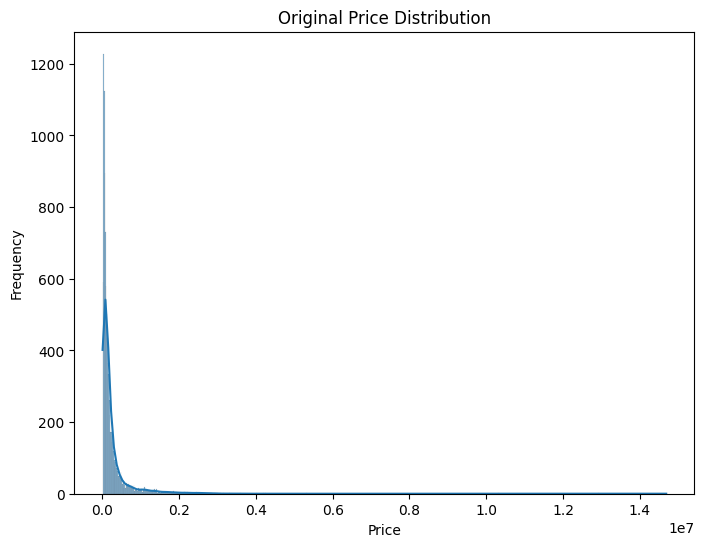

In [323]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the original price distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#### As you can see the distribution of car prices is right-skewed, with a some extremely high values. This means there are few outliers that pull the mean to the right making the data distribution uneven. Applying Log transformation will reduce the impact of those outliers and make the distribution symmetrical.

In [324]:
import numpy as np

# Apply log transformation to the price column
df['Log Price'] = np.log(df['Price'] + 1)

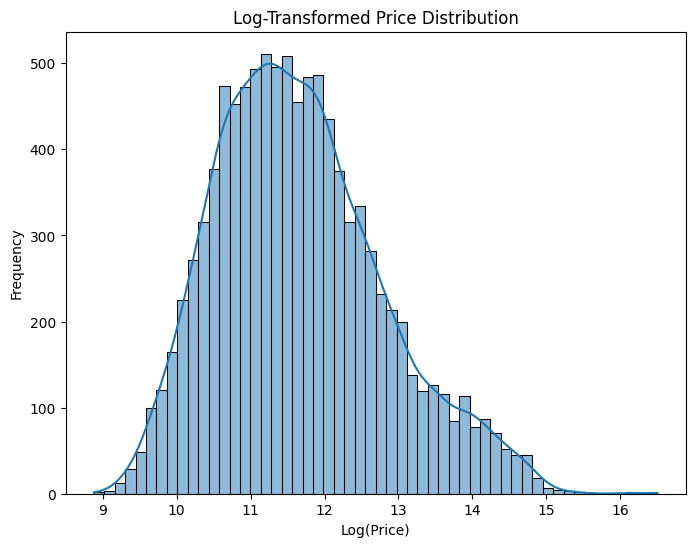

In [325]:
# Plot the log-transformed price distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Log Price'], kde=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

### Encoding categorical variables

In [326]:
# Make
# Model
# Body Type
# Cylinders
# Transmission
# Fuel Type
# Color

In [327]:
from sklearn.preprocessing import LabelEncoder

# transmission is a nominal categorical variable but only has two values. therefore used label encoder to encode it
# Automatic = 0, Manual = 1
label_encoder = LabelEncoder()
df['Transmission'] = label_encoder.fit_transform(df['Transmission'])

In [328]:
print(f"no of Fuel type categories: {len(df['Fuel Type'].value_counts())}")
print(f"categories of Fuel type")
print(df['Fuel Type'].value_counts())

no of Fuel type categories: 4
categories of Fuel type
Fuel Type
Gasoline    9714
Diesel       153
Electric     110
Hybrid        23
Name: count, dtype: int64


In [329]:
print(f"no of Body type categories: {len(df['Body Type'].value_counts())}")
print(f"categories of Body type")
print(df['Body Type'].value_counts())

no of Body type categories: 13
categories of Body type
Body Type
SUV                     4607
Sedan                   2790
Coupe                    837
Pick Up Truck            432
Hatchback                334
Sports Car               270
Van                      143
Hard Top Convertible     139
Crossover                136
Soft Top Convertible     120
Other                    114
Wagon                     44
Utility Truck             34
Name: count, dtype: int64


In [331]:
from sklearn.preprocessing import OneHotEncoder

# Since both fuel type and body type are nominal categorical variables with multiple categories One-hot encoding is used
nominal_categorical_cols = ['Fuel Type', 'Body Type']

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[nominal_categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(nominal_categorical_cols))
df = pd.concat([df.drop(nominal_categorical_cols, axis=1), one_hot_df], axis=1)

In [332]:
df.head()

,Make,Model,Year,Price,Mileage,Cylinders,Transmission,Color,Car Age,Mileage Per Year,...,Body Type_Hatchback,Body Type_Other,Body Type_Pick Up Truck,Body Type_SUV,Body Type_Sedan,Body Type_Soft Top Convertible,Body Type_Sports Car,Body Type_Utility Truck,Body Type_Van,Body Type_Wagon
0,toyota,camry,2016,47819.0,156500,4,0,Black,9,17388.888889,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,kia,sorento,2013,61250.0,169543,4,0,Grey,12,14128.583333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,mini,cooper,2023,31861.0,221583,4,0,Grey,2,110791.500000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,nissan,altima,2016,110322.0,69754,4,0,Red,9,7750.444444,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,toyota,land-cruiser-76-series,2020,139994.0,71399,4,1,White,5,14279.800000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [333]:
print(f"no of Model categories: {len(df['Model'].value_counts())}")
print(f"categories of model")
print(df['Model'].value_counts())

print(f"no of Make categories: {len(df['Make'].value_counts())}")
print(f"categories of make")
print(df['Make'].value_counts())

no of Model categories: 488
categories of model
Model
patrol               386
s-class              288
g-class              257
land-cruiser         208
range-rover-sport    198
                    ... 
centennial             1
aero-8                 1
dtsde-ville            1
trailblazer            1
ct5                    1
Name: count, Length: 488, dtype: int64
no of Make categories: 65
categories of make
Make
mercedes-benz    1486
nissan            925
toyota            893
bmw               698
ford              541
                 ... 
gac                 1
haval               1
baic                1
smart               1
morgan              1
Name: count, Length: 65, dtype: int64


In [ ]:
# pre processing steps
# 1) handle missing values
# 2) remove duplicates
# 3) handle outliers
# 4) Feature Engineering
# 5) encode categorical variables
# 6) normalize numerical features
# 7) remove irrelevant columns

In [ ]:
df=df.drop(["Location","Description"],axis=1)
df.head(5)